In [1]:
import matplotlib.pyplot as plt

In [2]:
import os
# load, split and scale the maps dataset ready for training
from os import listdir

In [3]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

In [4]:
from tensorflow.keras.initializers import RandomNormal
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from numpy import load
from numpy import zeros
from numpy import ones

from tensorflow.keras import Input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

In [5]:
LOAD_IMG_SIZE = 512

In [6]:
LOAD_IMG_DIM = (LOAD_IMG_SIZE,LOAD_IMG_SIZE)

In [7]:
IMG_CATEGORY="gogung"
IMG_DATE="day"

In [8]:
SRC_FOLDER = "gray"
TAR_FOLDER = "color"

In [9]:
TRAIN_ROOT_FOLDER = "./문화유산 이미지 자료/train3"

In [10]:
listdir(TRAIN_ROOT_FOLDER)

['color', 'gray']

In [11]:
# load all images in a directory into memory
def load_images(inpath, inorgpath, insize, srcFolder, tarFolder):
    src_list, tar_list = list(), list()
    for filename in listdir(inorgpath):
        try:
            srcpath = os.path.join(inpath,srcFolder,filename)
            tarpath = os.path.join(inpath,tarFolder,filename.replace("_gray","") )
            # load and resize the image
            srcPixels = load_img(srcpath, target_size=insize)
            tarPixels = load_img(tarpath, target_size=insize)
            # convert to numpy array
            srcPixels = img_to_array(srcPixels)
            tarPixels = img_to_array(tarPixels)
            # save into list
            src_list.append(srcPixels)
            tar_list.append(tarPixels)
        except Exception as e:
            print(e, srcpath)
        
    return [asarray(src_list), asarray(tar_list)]
 
# dataset path
path = TRAIN_ROOT_FOLDER
orgpath = os.path.join(path,SRC_FOLDER)
# load dataset
[src_images, tar_images] = load_images(inpath=path,
                                       inorgpath = orgpath,
                                       insize=LOAD_IMG_DIM,
                                       srcFolder = SRC_FOLDER,
                                       tarFolder = TAR_FOLDER)

In [12]:
print('Loaded: ', src_images.shape, tar_images.shape)
# 압축된 numpy array로 저장
filename = 'maps_{}.npz'.format(LOAD_IMG_SIZE)
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (50, 512, 512, 3) (50, 512, 512, 3)
Saved dataset:  maps_512.npz


### 이미지 확인`

In [13]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_{}.npz'.format(LOAD_IMG_SIZE))

src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

Loaded:  (50, 512, 512, 3) (50, 512, 512, 3)


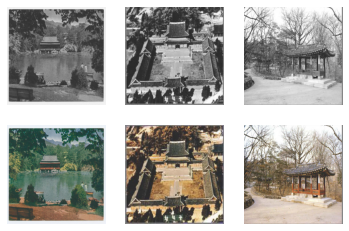

In [14]:
# plot source images
n_samples = 3
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))
plt.show()

###  * PatchGAN은 전체 영역이 아니라 특정 크기의 patch 단위로 Generator가 만든 이미지의 진위 여부를 판단

In [15]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

### generator

In [16]:
# 정의: 인코더 모델 정의
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # 가중치 초기화 (평균0, 표준편차 0.02)
    init = RandomNormal(stddev=0.02)
    # 다운샘플링 레이어 (합성곱 신경망)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    
    if batchnorm:
        g = BatchNormalization()(g, training=True)
        
    # 활성함수정의: leaky relu
    # gradient 미분값 변화량이 적어질경우 학습이 제대로 되지 않는다-> rel
    # 입력값이 음수일 때 출력값을 이 아닌 0.001과 같은 매우 작은 값을 출력하도록 설정 단, relu보다 계산량 많음
    g = LeakyReLU(alpha=0.2)(g)
    return g

# 정의: 디코더 모델 정의
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # 가중치 초기화 (평균0, 표준편차 0.02)
    init = RandomNormal(stddev=0.02)
    #  업샘플링 레리어 (합성곱 역)
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # 배치정규화 기본
    g = BatchNormalization()(g, training=True)
    # dropout 레이어는 요청시 정의
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # 스킵인 레이어와 통합 (동일크기의 기존 이미지 정보 skip in)
    g = Concatenate()([g, skip_in])
    # 활성함수정의: relu
    g = Activation('relu')(g)
    return g

# 정의: 생성자 모델 정의
def define_generator(image_shape=(LOAD_IMG_SIZE,LOAD_IMG_SIZE,3)):
    # 가중치 초기화 (평균 0, 표준편차 0.02)
    init = RandomNormal(stddev=0.02)
    
    # 1. 인풋레이어 정의 ( 이미지사이즈) 인코더 모델 (conv레이어 + Leakly Relu 조합)
    in_image = Input(shape=image_shape)
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    
    # 2. 히든레이어 정의 (conv레이어 + Leakly Relu 조합)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # 디코더 모델 (convTranspost 레이어 + relu 조합)
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    
    # 3. 아웃풋레이어 정의 하이퍼볼릭 탄젠트 (-1~1) 정의
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    # 모델 정의 (input, output) 조립 
    model = Model(in_image, out_image)
    return model

In [17]:
# 생성자모델 업데이트를 위한 생성자 및 판별자 조합 모델
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # 이미지소스를 생성자 모델에 연결
    gen_out = g_model(in_src)
    # 입력소스 및 생성자 출력결과를 판별자 input에 연결 connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # 모델정의 (input, ouput, input 이미지, output: 출력결과, 생성자 출력결과)
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    # 모델 컴파일
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy","mae"], optimizer=opt, loss_weights=[1,100])
    return model

In [18]:
# load and prepare training images
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [19]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [20]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [21]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_{}_{}.h5'.format(IMG_CATEGORY, IMG_DATE)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [22]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # 판별자(Descriminator)의 출력 shape 정의 (예: 32)
    n_patch = d_model.output_shape[1]
    # trainA, trainB = 훈련데이터의 흑백이미지, 컬러이미지
    trainA, trainB = dataset
    # 에포크별 배치 수 연산 (예: 이미지 50장 배치 1 -> 50 )
    bat_per_epo = int(len(trainA) / n_batch)
    # 반복횟수 연산(예: 500 * 에포크(11) = 500)
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # 정의: 훈련이미지 중 흑백/컬러 샘플 1장(n_batch) 선택 및 1장의 1로 채운 patch shape (1, 32, 32, 1) 반환
        # 정의 데이터를 불러와서 문제지/정답지 이미지 한케이스 및 판별자 출력값과 같은 차원의 1 값 반환
        # 파라미터 : dataset: 훈련 이미지 (-1~1사이)
        #           n_batch: 배치 사이즈 (1)
        #           n_patch: 판별자 출력결과 크기 (32)
        # 출력값: X_realA: 흑백 이미지
        #        X_realB: 컬러 이미지
        #         y_real: 정답지 (1, 32, 32, 1)
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

        # 정의: 배치훈련을 위한 가짜 샘플 생성
        # 파라미터: g_model: 생성자 (다운/업샘플링)
        #          X_realA: 흑백이미지 샘플 1장 
        #          n_patch: 판별자 출력 shape 32
        # XrealA(훈련데이터의 흑백이미지를 넣고 생성자로 예측) -> 1,512,512,3
        # 이후  판별자 shape크기에 값1 채운값 생성 (예: 1,32,32,1 shape)
        # 출력값: X_fakeB: 흑백사진 넣고 생성자 모델을 통해 예측된 이미지 결과
        #        y_fake: 1,32,32,1 판별자 출력 크기의 0으로 채운 값
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

        # 정의: 판별자 모델 업데이트 (훈련데이터중 컬러/흑백 사진 및 1 결과 넣음)
        # 파라미터 : X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지]
        #           X_realB: 훈련데이터중 랜덤하게 뽑은 컬러사진 1장 [답지]
        #           y_real: 판별자 1로 훈련
        # 출력값: 판별자 Loss1
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

        # 정의: 판별자 모델 업데이트 ( 생성자를 통해 생성된 이미지 활용 )
        # 파라미터 : X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지]
        #           X_fakeB: 흑백사진 넣고 생성자 모델을 통해 예측된 이미지 결과
        # 출력:     y_fake: 1,32,32,1 판별자 출력 크기의 0으로 채운 값
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

        # 정의: 생성자 모델 업데이트
        # 파라미터: X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지] -> input image shape
        #          y_real: 판별자 1로 훈련 -> 판별자 출력결과
        #          X_realB: 훈련데이터중 랜덤하게 뽑은 컬러사진 1장 [답지] -> 생성자 출력
        # 출력: loss   
        g_loss,_,_ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        # 스탭별 loss 출력
        print("{} step d_loss1: {}, d_loss2: {}, g_loss: {}".format(i+1, d_loss1, d_loss2, g_loss) )

        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [23]:
# def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
#     # determine the output square shape of the discriminator
#     n_patch = d_model.output_shape[1]
#     # unpack dataset
#     trainA, trainB = dataset
#     # calculate the number of batches per training epoch
#     bat_per_epo = int(len(trainA) / n_batch)
#     # calculate the number of training iterations
#     n_steps = bat_per_epo * n_epochs
#     # manually enumerate epochs
#     for i in range(n_steps):
#         # select a batch of real samples
#         [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
#         # generate a batch of fake samples
#         X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
#         # update discriminator for real samples
#         d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
#         # update discriminator for generated samples
#         d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
#         # update the generator
#         g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
#         # summarize performance
#         print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
#         # summarize model performance
#         if (i+1) % (bat_per_epo * 10) == 0:
#             summarize_performance(i, g_model, dataset)

### 1. 이미지 불러오기

In [24]:
# 이미지 데이터 불러오기 (예:512*512) 사이즈로 변환 및 -1~1사리오 변환된 이미지 (+1/2 해야함)
dataset = load_real_samples('maps_{}.npz'.format(LOAD_IMG_SIZE))
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (50, 512, 512, 3) (50, 512, 512, 3)


In [25]:
# 불러온 데이터를 가지고 모델에 적용하기 위한 input_shape 정의 (예: 512,512,3)
image_shape = dataset[0].shape[1:]

In [26]:
# 모델정의
# d_model: 판별 모델 patch gan
# g_model: u-net정의
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

C:\Users\SMART-22\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [27]:
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset, n_epochs=11)

1 step d_loss1: 0.44070136547088623, d_loss2: 0.727205216884613, g_loss: 41.07831573486328
2 step d_loss1: 0.5624027252197266, d_loss2: 0.6732653379440308, g_loss: 62.681434631347656
3 step d_loss1: 0.7556185722351074, d_loss2: 1.0821783542633057, g_loss: 47.12175750732422
4 step d_loss1: 0.3409571051597595, d_loss2: 0.8116776347160339, g_loss: 30.72222900390625
5 step d_loss1: 0.3176960051059723, d_loss2: 0.5477461814880371, g_loss: 37.931419372558594
6 step d_loss1: 0.3591243326663971, d_loss2: 0.4590771198272705, g_loss: 35.94966506958008
7 step d_loss1: 0.3631775975227356, d_loss2: 0.45534998178482056, g_loss: 39.185569763183594
8 step d_loss1: 0.3683587312698364, d_loss2: 0.43039917945861816, g_loss: 23.59782600402832
9 step d_loss1: 0.4143374264240265, d_loss2: 0.42338550090789795, g_loss: 28.08684539794922
10 step d_loss1: 0.42988112568855286, d_loss2: 0.3718181848526001, g_loss: 35.72376251220703
11 step d_loss1: 0.3769100308418274, d_loss2: 0.40059974789619446, g_loss: 40.2977

### 디버깅

In [116]:
# train(d_model, g_model, gan_model, dataset, n_epochs=11)

In [117]:
n_epochs = 11
n_batch = 1

In [118]:
# 판별자(Descriminator)의 출력 shape 정의 (예: 32)
n_patch = d_model.output_shape[1]

In [119]:
# trainA = 흑백이미지, 컬러이미지
trainA, trainB = dataset

In [120]:
# eachImg = trainB[0]+1/2
# plt.imshow(eachImg)

In [121]:
# 에포크별 배치 수 연산 (예: 이미지 50장 배치 1 -> 50 )
bat_per_epo = int(len(trainA) / n_batch)

In [122]:
# 반복횟수 연산(예: 500 * 에포크(11) = 500)
n_steps = bat_per_epo * n_epochs

In [123]:
i=0

In [124]:
# 정의: 훈련이미지 중 흑백/컬러 샘플 1장(n_batch) 선택 및 1장의 1로 채운 patch shape (1, 32, 32, 1) 반환
# 정의 데이터를 불러와서 문제지/정답지 이미지 한케이스 및 판별자 출력값과 같은 차원의 1 값 반환
# 파라미터 : dataset: 훈련 이미지 (-1~1사이)
#           n_batch: 배치 사이즈 (1)
#           n_patch: 판별자 출력결과 크기 (32)
# 출력값: X_realA: 흑백 이미지
#        X_realB: 컬러 이미지
#         y_real: 정답지 (1, 32, 32, 1)
[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

# 정의: 배치훈련을 위한 가짜 샘플 생성
# 파라미터: g_model: 생성자 (다운/업샘플링)
#          X_realA: 흑백이미지 샘플 1장 
#          n_patch: 판별자 출력 shape 32
# XrealA(훈련데이터의 흑백이미지를 넣고 생성자로 예측) -> 1,512,512,3
# 이후  판별자 shape크기에 값1 채운값 생성 (예: 1,32,32,1 shape)
# 출력값: X_fakeB: 흑백사진 넣고 생성자 모델을 통해 예측된 이미지 결과
#        y_fake: 1,32,32,1 판별자 출력 크기의 0으로 채운 값
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

# 정의: 판별자 모델 업데이트 (훈련데이터중 컬러/흑백 사진 및 1 결과 넣음)
# 파라미터 : X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지]
#           X_realB: 훈련데이터중 랜덤하게 뽑은 컬러사진 1장 [답지]
#           y_real: 판별자 1로 훈련
# 출력값: 판별자 Loss1
d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

# 정의: 판별자 모델 업데이트 ( 생성자를 통해 생성된 이미지 활용 )
# 파라미터 : X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지]
#           X_fakeB: 흑백사진 넣고 생성자 모델을 통해 예측된 이미지 결과
# 출력:     y_fake: 1,32,32,1 판별자 출력 크기의 0으로 채운 값
d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

# 정의: 생성자 모델 업데이트
# 파라미터: X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지] -> input image shape
#          y_real: 판별자 1로 훈련 -> 판별자 출력결과
#          X_realB: 훈련데이터중 랜덤하게 뽑은 컬러사진 1장 [답지] -> 생성자 출력
# 출력: loss   
g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])

# 스탭별 loss 출력
print("{} step d_loss1: {}, d_loss2: {}, g_loss: {}".format(i+1, d_loss1, d_loss2, g_loss) )

# summarize model performance
if (i+1) % (bat_per_epo * 10) == 0:
    summarize_performance(i, g_model, dataset)

In [ ]:
# manually enumerate epochs
for i in range(n_steps):
    # 정의: 훈련이미지 중 흑백/컬러 샘플 1장(n_batch) 선택 및 1장의 1로 채운 patch shape (1, 32, 32, 1) 반환
    # 정의 데이터를 불러와서 문제지/정답지 이미지 한케이스 및 판별자 출력값과 같은 차원의 1 값 반환
    # 파라미터 : dataset: 훈련 이미지 (-1~1사이)
    #           n_batch: 배치 사이즈 (1)
    #           n_patch: 판별자 출력결과 크기 (32)
    # 출력값: X_realA: 흑백 이미지
    #        X_realB: 컬러 이미지
    #         y_real: 정답지 (1, 32, 32, 1)
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

    # 정의: 배치훈련을 위한 가짜 샘플 생성
    # 파라미터: g_model: 생성자 (다운/업샘플링)
    #          X_realA: 흑백이미지 샘플 1장 
    #          n_patch: 판별자 출력 shape 32
    # XrealA(훈련데이터의 흑백이미지를 넣고 생성자로 예측) -> 1,512,512,3
    # 이후  판별자 shape크기에 값1 채운값 생성 (예: 1,32,32,1 shape)
    # 출력값: X_fakeB: 흑백사진 넣고 생성자 모델을 통해 예측된 이미지 결과
    #        y_fake: 1,32,32,1 판별자 출력 크기의 0으로 채운 값
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

    # 정의: 판별자 모델 업데이트 (훈련데이터중 컬러/흑백 사진 및 1 결과 넣음)
    # 파라미터 : X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지]
    #           X_realB: 훈련데이터중 랜덤하게 뽑은 컬러사진 1장 [답지]
    #           y_real: 판별자 1로 훈련
    # 출력값: 판별자 Loss1
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

    # 정의: 판별자 모델 업데이트 ( 생성자를 통해 생성된 이미지 활용 )
    # 파라미터 : X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지]
    #           X_fakeB: 흑백사진 넣고 생성자 모델을 통해 예측된 이미지 결과
    # 출력:     y_fake: 1,32,32,1 판별자 출력 크기의 0으로 채운 값
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

    # 정의: 생성자 모델 업데이트
    # 파라미터: X_realA: 훈련데이터중 랜덤하게 뽑은 흑백사진 1장 [문제지] -> input image shape
    #          y_real: 판별자 1로 훈련 -> 판별자 출력결과
    #          X_realB: 훈련데이터중 랜덤하게 뽑은 컬러사진 1장 [답지] -> 생성자 출력
    # 출력: loss   
    g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])

    # 스탭별 loss 출력
    print("{} step d_loss1: {}, d_loss2: {}, g_loss: {}".format(i+1, d_loss1, d_loss2, g_loss) )

    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
        summarize_performance(i, g_model, dataset)